# Lour's Pork Barrel Classifier (羅老師肉桶文本分類器)🐖
## Convolutional Neural Networks for Pork Barrel Project Classification 

-------------------------

### Stage 1: Libaries & Dependencies

In [1]:
# built-in library
import math
import re
import collections
import zipfile
import random
from itertools import chain

# ML & Deep Learning/ NLP toolkit
import pandas as pd
import numpy as np
import jieba
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

-------------------------

### Stage 2: Data Preprocessing (Training Data: Introduction of Bills and Legislation from 6th Session to 7th Session, 2004-2012)

#### (1) Read file 

In [2]:
# read file
df = pd.read_csv('data/Pork Bill - 2021-05-20.csv',encoding='utf-8')

# combine abstract of bill and title 
df['text'] =  df['Title'] + df['Content'].fillna(df['Title'])

# drop conten without having any characters
# view na's row: df[df['text'].isnull()==True]
data = df[['text', 'pork_bill']].dropna(subset=['text'])

In [3]:
print(" Pork Legislation", data['pork_bill'].value_counts()[1],'\n', 
      "None-Pork Legislation", data['pork_bill'].value_counts()[0])

 Pork Legislation 2510 
 None-Pork Legislation 4733


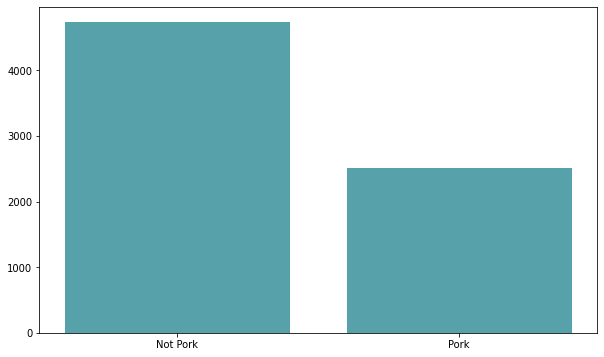

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
pork_plot = pd.DataFrame({"num":data['pork_bill'].value_counts(), "type":['Not Pork','Pork']})
plt.bar(pork_plot['type'], pork_plot['num'], color='#57A1AB')
#plt.show()
plt.savefig('images/full_plot.png')

#### (2) Tokenization

In [5]:
import collections
import numpy as np
import jieba
from itertools import chain


def jieba_cut(filename):
    """
    cut Chinese and remove stop words
    Reference: https://www.cnblogs.com/Luv-GEM/p/10836454.html
    Stopwords: https://www.kaggle.com/rikdifos/english-and-chinese-stopwords?select=cn_stopwords.txt
    """
    stop_list = [i.strip() for i in open('cn_stopwords.txt','r',encoding='utf-8')]  
    news_cut = []
    news_list = []
    for line in filename:    
        if line:
            news_cut = list(jieba.cut(''.join(line),cut_all=False,HMM=True))  
            news_list.append([word.strip() for word in news_cut if word not in stop_list and len(word.strip())>0]) 
    news_list = list(chain.from_iterable(news_list))  
    return news_list

def clearPucts(context):
    """
    remove punctuation
    ref: https://chenyuzuoo.github.io/posts/28001/
    """
    context = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "", context)
    context = re.sub("[【】╮╯▽╰╭★→「」]+","", context)
    context = re.sub("！，❤。～《》：（）【】「」？”“；：、","",context)
    context = re.sub("\s","",context)
    return context

def seg_char(sent):
    """
    cut Chinese and remove stop words
    ref: https://blog.csdn.net/renyuanfang/article/details/86487367
    """
    # split
    pattern_char_1 = re.compile(r'([\W])')
    parts = pattern_char_1.split(sent)
    parts = [p for p in parts if len(p.strip())>0]
    # cut sentence
    pattern = re.compile(r'([\u4e00-\u9fa5])')
    chars = pattern.split(sent)
    chars = [w for w in chars if len(w.strip())>0]
    chars = ' '.join(chars)
    return chars

In [6]:
data_clean = [seg_char(text) for text in [clearPucts(text) for text in data.text]]

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**18)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

#### (3) Padding

In [7]:
MAX_LEN = max([len(sentence) for sentence in data_clean])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)

print('Maximun length:{} \nInput:{}'.format(MAX_LEN, data_inputs.shape[0]))


Maximun length:785 
Input:7243


#### (4) Spliting Training / Testing Set

In [8]:
data_labels = data.pork_bill.values

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    data_inputs, data_labels, test_size=0.33, random_state=42)

print("Shape of X Train:", train_inputs.shape, '\n'
      "Shape of X Test :", test_inputs.shape,'\n'
      "Shape of Y Trian:", train_labels.shape , '\n'
      "Shape of Y Test :", test_labels.shape )

Shape of X Train: (4852, 785) 
Shape of X Test : (2391, 785) 
Shape of Y Trian: (4852,) 
Shape of Y Test : (2391,)


In [10]:
unique_train_labels, counts_train_labels = np.unique(train_labels, return_counts=True)

print(' Num of Train Set:' , train_inputs.shape[0], '\n'
      ,'Not Pork vs Pork:', dict(zip(unique_train_labels, counts_train_labels)))

 Num of Train Set: 4852 
 Not Pork vs Pork: {0: 3167, 1: 1685}


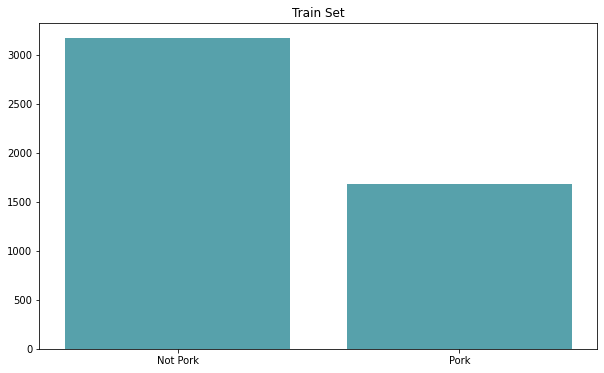

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
train_plot = pd.DataFrame({"num":[dict(zip(unique_train_labels, counts_train_labels))[0],
                                  dict(zip(unique_train_labels, counts_train_labels))[1]], 
                           "type":['Not Pork','Pork']})
plt.bar(train_plot['type'], train_plot['num'], color='#57A1AB')
plt.title('Train Set')
#plt.show()
plt.savefig('images/train_plot.png')

In [12]:
unique_test_labels, counts_test_labels = np.unique(test_labels, return_counts=True)

print(' Num of Test Set:' , test_inputs.shape[0], '\n'
      ,'Not Pork vs Pork:', dict(zip(unique_test_labels, counts_test_labels)))

 Num of Test Set: 2391 
 Not Pork vs Pork: {0: 1566, 1: 825}


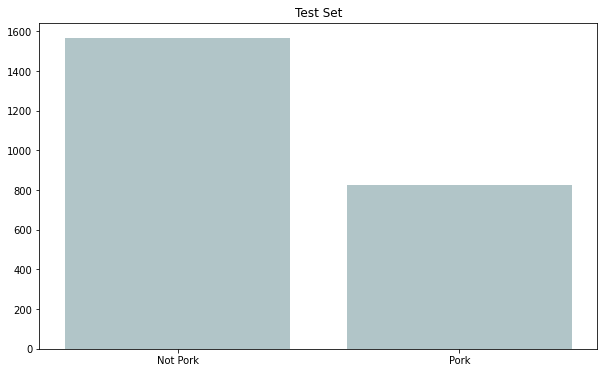

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
test_plot = pd.DataFrame({"num":[dict(zip(unique_test_labels, counts_test_labels))[0],
                                 dict(zip(unique_test_labels, counts_test_labels))[1]], 
                          "type":['Not Pork','Pork']})
plt.bar(test_plot['type'], test_plot['num'], color='#B1C5C8')
plt.title('Test Set')
#plt.show()
plt.savefig('images/test_plot.png')

-------------------------


### Stage 3: Model and Building

#### (1) Using the Subclassing API to Build Dynamic Model

In [14]:
class DCNN(tf.keras.Model):
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=100,
                 # units: Positive integer, dimensionality of the output space.
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="PorkCNN"):
        super(DCNN, self).__init__(name=name)
        self.embedding = layers.Embedding(vocab_size, emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, strides = 1, padding="valid", activation="relu")
        self.bigram2 = layers.Conv1D(filters=nb_filters, kernel_size=2, strides = 2, padding="valid", activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,kernel_size=3,strides = 1, padding="valid",activation="relu")
        self.trigram2 = layers.Conv1D(filters=nb_filters,kernel_size=3,strides = 2, padding="valid",activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,kernel_size=4,strides = 2, padding="valid",activation="relu")
        self.fivegram = layers.Conv1D(filters=nb_filters,kernel_size=5,strides = 2, padding="valid",activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.last_dense = layers.Dense(units=1, activation="sigmoid")    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_1_1 = self.bigram2(x)
        x_1_1 = self.pool(x_1_1)        
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_2_1 = self.trigram2(x)
        x_2_1 = self.pool(x_2_1)     
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        x_4 = self.fourgram(x)
        x_4 = self.pool(x_4) 
        x_5 = self.fivegram(x)
        x_5 = self.pool(x_5)      
        merged = tf.concat([x_1,x_1_1, x_2,x_2_1, x_3, x_4, x_5], axis=-1) 
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)        
        return output

In [15]:
VOCAB_SIZE = tokenizer.vocab_size #tokenizer.vocab_size  # 5000 tokenizer.vocab_size
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2 #len(set(train_labels))
DROPOUT_RATE = 0.25
BATCH_SIZE = 230
NB_EPOCHS = 80

Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

#### (2) Compile and Summary of the Model

In [16]:
Dcnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
Dcnn.build(input_shape = (train_inputs.shape[1], EMB_DIM)) # (train_inputs.shape[1] , EMB_DIM)  (785 , EMB_DIM)
Dcnn.summary()

Model: "PorkCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  586600    
_________________________________________________________________
conv1d (Conv1D)              multiple                  40100     
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  40100     
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_3 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_4 (Conv1D)            multiple                  80100     
_________________________________________________________________
conv1d_5 (Conv1D)            multiple                  1001

#### (3) Check Point Path

In [17]:
checkpoint_path = "checkpoint_recode/ckpt_manager"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Checkpoint Located!!")

-------------------------

### Stage 4: Train the Model

#### (1) Set up the Check-point Path

In [18]:
checkpoint_path = "checkpoint_recode/ckpt_manager"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Checkpoint Located!!")

#### (2) Define the TensorBoard Callback
ref: https://www.tensorflow.org/tensorboard/get_started

In [19]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      write_images=True,
                                                      histogram_freq=1)


#### (3) Define the EarlyStopping Callback
Stop training when a monitored metric has stopped improving. ref:https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [20]:
early_stop = EarlyStopping(monitor='val_loss',patience=5, verbose=1)

#### (4) Training the Model


In [21]:
Dcnn.fit(train_inputs, train_labels,
         validation_data=(test_inputs, test_labels),
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS,
         callbacks=[early_stop, tensorboard_callback])
ckpt_manager.save()

Epoch 1/80
22/22 [==============================] - 43s 2s/step - loss: 0.5897 - accuracy: 0.6739 - val_loss: 0.4618 - val_accuracy: 0.8168
Epoch 2/80
22/22 [==============================] - 48s 2s/step - loss: 0.3336 - accuracy: 0.8658 - val_loss: 0.2367 - val_accuracy: 0.9097
Epoch 3/80
22/22 [==============================] - 54s 2s/step - loss: 0.1545 - accuracy: 0.9437 - val_loss: 0.1647 - val_accuracy: 0.9419
Epoch 4/80
22/22 [==============================] - 48s 2s/step - loss: 0.0784 - accuracy: 0.9773 - val_loss: 0.1543 - val_accuracy: 0.9456
Epoch 5/80
22/22 [==============================] - 47s 2s/step - loss: 0.0517 - accuracy: 0.9843 - val_loss: 0.1606 - val_accuracy: 0.9515
Epoch 6/80
22/22 [==============================] - 48s 2s/step - loss: 0.0527 - accuracy: 0.9862 - val_loss: 0.1815 - val_accuracy: 0.9402
Epoch 7/80
22/22 [==============================] - 46s 2s/step - loss: 0.0468 - accuracy: 0.9845 - val_loss: 0.1746 - val_accuracy: 0.9460
Epoch 8/80
22/22 [==

'checkpoint_recode/ckpt_manager/ckpt-1'

-------------------------

### Stage 5: Evaluation

In [22]:
losses = pd.DataFrame(Dcnn.history.history)
losses

,loss,accuracy,val_loss,val_accuracy
0,0.589721,0.673949,0.461788,0.816813
1,0.333602,0.865829,0.236699,0.909661
2,0.154537,0.943735,0.164732,0.941865
3,0.078391,0.977329,0.154276,0.945629
4,0.051655,0.984336,0.160593,0.951485
5,0.052688,0.986191,0.181491,0.940192
6,0.046806,0.984542,0.174556,0.946048
7,0.040925,0.986810,0.174895,0.947721
8,0.039176,0.985573,0.175396,0.947302


<AxesSubplot:>

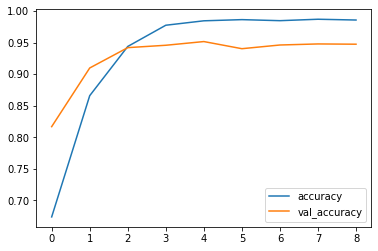

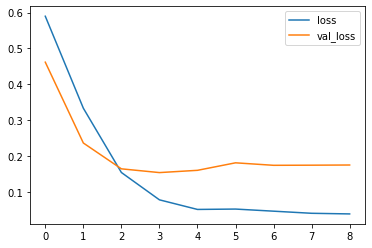

In [23]:
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()

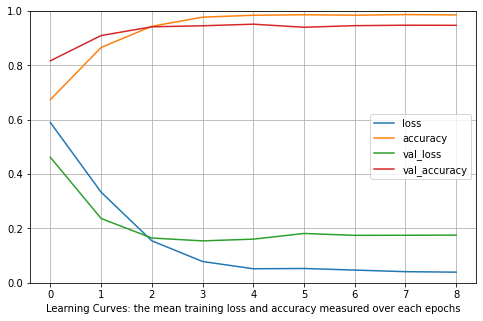

In [24]:
losses.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel("Learning Curves: the mean training loss and accuracy measured over each epochs")
plt.savefig('images/learning_curves3.png')
plt.show()


In [25]:
from sklearn.metrics import classification_report,confusion_matrix
evaluation_model = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(evaluation_model)

11/11 [==============================] - 6s 561ms/step - loss: 0.1754 - accuracy: 0.9473
[0.17539633810520172, 0.9473024010658264]


In [26]:
# pd.DataFrame(confusion_matrix(test_labels,predictions))
predictions = Dcnn.predict(test_inputs)
predictions = np.where(predictions >0.8 , 1, 0)
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1566
           1       0.95      0.90      0.92       825

    accuracy                           0.95      2391
   macro avg       0.95      0.94      0.94      2391
weighted avg       0.95      0.95      0.95      2391



In [27]:
t = pd.DataFrame(confusion_matrix(test_labels,predictions), 
             columns=['Predictions: Not Pork(0)','Predictions:Pork(1)'])
t.index = ['Acutal: Not Pork(0)', 'Acutal: Pork (1)']
t

,Predictions: Not Pork(0),Predictions:Pork(1)
Acutal: Not Pork(0),1523,43
Acutal: Pork (1),82,743


### Stage 6: Call up Tensorboard

In [28]:
%load_ext tensorboard

%tensorboard --logdir logs/fit

-------------------------

### Stage 8: Try the Model with New Data and Export an End-to-end Model


#### (1) Test New Dataset from 2000 samples from Legislative Questions from 6th Session 

In [29]:
def as_num(x):
    """
    keep 10 decimals
    """
    y = '{:.15f}'.format(x) 
    return y

In [30]:
import pandas as pd
import random

# test the trined model using new text from 200 samples from Leislative Questions
LQ6 = pd.read_csv('data/LQ_6th.csv')

# drop '0': legislor  never have proposed any legisaltive questions. 
LQ6 = LQ6[LQ6['title'].isin(['0'])== False]

# select text with number of charecters within EMB_DIM; len(sub_set) = 11162
# sample_df = LQ6.loc[[len(char_num) for char_num in LQ6.title if len(char_num) < MAX_LEN], ['legislator','title', 'topic', 'category', 'keywords', 'ques_type']].reset_index(drop=True)
random.seed(42)
sample_df = LQ6.iloc[random.sample(range(len(LQ6)), 2000)][['legislator', 'title', 'topic', 'category', 'keywords', 'ques_type']]
sub_set = [seg_char(text) for text in [clearPucts(text) for text in sample_df.title]]


##### Top 10 of 2000 Samples

In [31]:
pd.DataFrame(
    {'legislator': sample_df.legislator,
     'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).head(15)

,legislator,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
9892,陳啟昱,0.999573826789856,鑑於現行《所得稅法》第十七條規定特別扣除額教育支出部分，僅以納稅義務人之子女就讀大專院校為限...,所得稅 ; 教育費用 ; 扣除額,所得稅法 ; 特別扣除額 ; 教育支出
3999,林正峰,0.998221218585968,針對政府準備修法推動「二代健保」，健保保費採取「年度所得總額」為計算基礎，而非採用扣除免稅額...,國民 ; 健康保險 ; 保險費,二代健保 ; 年度所得總額
1761,彭添富,0.996832251548767,針對「辦理九十四年原住民中低收入戶家庭租屋補助計畫」專案補助計畫，特向行政院提出質詢。,原住民族生活,原住民中低收入戶 ; 租屋補助
1296,廖婉汝,0.994153439998627,針對高高屏三縣市家庭收入偏低，要求政府應設法為高高屏三縣市創造就業機會，以提高高高屏三縣市之...,貧富差距 ; 低收入戶 ; 失業,家庭收入 ; 就業機會
4546,林鴻池,0.991988241672516,針對諸多已獲得五年五百億與卓越計畫獎補助的大學擬調漲學雜費，但教育部長杜正勝曾承諾，獲得上述...,教育補助 ; 教育費用 ; 大學,卓越計畫獎補助 ; 大學學費
188,丁守中,0.989335179328918,針就「國軍退除役官兵就養安置辦法」第七條第一項第五款規定：「全家人口所有之土地及房屋公告現值...,退除役官兵 ; 榮民生活輔導,國軍退除役官兵就養安置辦法
6899,王昱婷,0.986667394638062,針對根據內政部最新統計，國內的嬰兒出生率再創新低點，今年1到4月只有6萬5400個小嬰兒出生...,出生率 ; 人口政策,出生率 ; 生育率
1706,彭添富,0.983055114746094,針對「觀音鄉保生社區風貌營造規劃設計」專案補助計畫，特向行政院提出質詢。,社區計畫 ; 政府補助,保生社區
4553,林鴻池,0.981910467147827,針對行政院宣布補助弱勢家庭子女就讀私校高中職之學費，卻將資格限制在「非自願就讀者」，有畫餅充...,低收入戶 ; 教育補助,弱勢家庭 ; 私立高中職
8340,蔡煌瑯(離職),0.975867986679077,「2005南投花卉嘉年華」活動爭取中央經費補助案由，特向行政院提出質詢。,農業推廣 ; 政府補助,南投花卉嘉年華 ; 中央經費


##### Last 10 Rows of 2000 Samples

In [32]:
pd.DataFrame(
    {'legislator': sample_df.legislator,
     'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).tail(15)

,legislator,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
982,周守訓,0.000017133843357,針對日前媒體報導陳水扁總統宣示，十二月二十五日耶誕節是重要的宗教節慶，更是我國的行憲紀念日，...,宗教 ; 假日,耶誕節 ; 行憲紀念日 ; 宗教自由 ; 政教分離
6201,王幸男,0.000016075460735,針對近日本最高法院針對纏訟四十年的京都「光華寮」案件做成判決，判決內容值得我們關注。日本最高...,公有建築物 ; 國際仲裁 ; 外交承認,日本 ; 光華寮 ; 判決 ; 外交承認
9039,邱毅,0.000015814948711,針對新聞局認定TVBS應為綜合台非新聞台乙案，準備將TVBS轉頻一事，日前行政院新聞局認定T...,新聞自由 ; 電視臺,TVBS ; 股權結構 ; 外資 ; 國家通訊傳播委員會組織法 ; NCC ; 報導自由
987,周守訓,0.000013057484466,針對中選會擬在年底三合一選舉，取消投票人領票後在身分證上蓋印戳記的措施，再度掀起軒然大波。在...,選務 ; 國民身分證,三合一選舉 ; 身分證 ; 戳記
9975,陳朝容,0.000012605133634,針對日前新聞報導「謝老師減肥茶」涉不實廣告代言，而且該食品已有消費者食用導致身亡，有鑒於市場...,廣告 ; 食品管理,廣告代言 ; 減肥 ; 健康食品
8839,賴清德,0.000012148648239,針對市售豆類製品疑含「過氧化氫」情形嚴重，傷害消費者健康，爰要求相關單位依食品衛生管理法切實...,食品管理,豆類製品 ; 過氧化氫
1504,張顯耀,0.000011832543350,針對整合警力資源、擴大警政服務範疇，建議行政院將現行警政署、海岸巡防署、消防署及入出境管理局...,政府組織,警力資源 ; 警政服務 ; 警政總署
5160,沈智慧,0.000011133596672,針對考試院修正特種考試地方政府公務人員考試規則，新增並刪減多項類科，且將三等、四等及五等考試...,國家考試,國家考試 ; 憲法
7514,紀國棟,0.000007990905942,鑒於台灣極力發展觀光倍增之際，竟一再傳出中國觀光客來台糾紛頻傳，爰要求觀光局為下列改進：一、...,旅遊業 ; 觀光,中國觀光客 ; 旅遊糾紛
1299,廖婉汝,0.000006711962214,針對近來警界風紀事件頻傳，身為人民保母的員警卻屢屢傳出知法犯法、違法亂紀的情形，嚴重侵害到人...,警察風紀,警界風紀


#### (2) Export an End-to-end Model


In [33]:
from tensorflow.keras.models import load_model

In [34]:
# Get model (Sequential, Functional Model, or Model subclass)
Dcnn.save('lour_pork_model')

INFO:tensorflow:Assets written to: lour_pork_model/assets


INFO:tensorflow:Assets written to: lour_pork_model/assets


In [35]:
from tensorflow import keras
model = keras.models.load_model('lour_pork_model')